In [1]:
import pandas as pd
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read in Data

In [2]:
df = pd.read_json(file_path)
pd.set_option('display.max_columns', 20)

In [3]:
df.head()

,login_time
0,2010-01-01 00:11:52
1,2010-01-01 00:13:00
2,2010-01-01 00:14:49
3,2010-01-01 00:21:00
4,2010-01-01 00:23:05


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97423 entries, 0 to 97422
Data columns (total 1 columns):
login_time    97423 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.5 MB


In [5]:
# Data is missing after 2010-08-28 15pm. We need to take this into account when doing analysis.
df.describe()

,login_time
count,97423
unique,97423
top,2010-02-20 23:16:00
freq,1
first,2010-01-01 00:11:52
last,2010-08-28 14:47:00


In [6]:
# Set login_time as index, aggregate login counts based on 15 minutes intervals.
df.set_index('login_time', inplace=True)
df['login_time_count'] = 1
df = df.resample('15T').count()

In [7]:
# Create year, month, day, hour, dayofweek(Monday till Sunday) weekend(whether or not weekend)\
# columns.
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute_interval'] = df.index.minute
df['dayofweek'] = df.index.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if x in range(5,7) else 0)
df['dayofweek_1'] = df['dayofweek'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',\
                                    4:'Friday', 5:'Saturday', 6:'Sunday'})

In [8]:
df.head()

,login_time_count,year,month,day,hour,minute_interval,dayofweek,weekend,dayofweek_1
login_time,,,,,,,,,
2010-01-01 00:00:00,3,2010,1,1,0,0,4,0,Friday
2010-01-01 00:15:00,3,2010,1,1,0,15,4,0,Friday
2010-01-01 00:30:00,7,2010,1,1,0,30,4,0,Friday
2010-01-01 00:45:00,7,2010,1,1,0,45,4,0,Friday
2010-01-01 01:00:00,5,2010,1,1,1,0,4,0,Friday


# Check Data Quality

In [9]:
def check_data_quality(df):
    for month in range(1, 9):
        for day in range(1,32):
            print 'month{} day{}'.format(month, day), df[(df.month == month) & (df.day == day)].hour.unique()

In [10]:
# We can see we don't have time interval for August 29th, 30th and 31st. We only have hour\
# record from 0 to 14 on August 28th. This reaffirmed our previous observation.
# check_data_quality(df)

In [11]:
# Because of incomplete records in August, we deide not to include August in our analysis. In \
# the future, we can analyze August data alone, or impute missing data from other relevant records.
df_new = df[df.month != 8]

In [12]:
df_new.head()

,login_time_count,year,month,day,hour,minute_interval,dayofweek,weekend,dayofweek_1
login_time,,,,,,,,,
2010-01-01 00:00:00,3,2010,1,1,0,0,4,0,Friday
2010-01-01 00:15:00,3,2010,1,1,0,15,4,0,Friday
2010-01-01 00:30:00,7,2010,1,1,0,30,4,0,Friday
2010-01-01 00:45:00,7,2010,1,1,0,45,4,0,Friday
2010-01-01 01:00:00,5,2010,1,1,1,0,4,0,Friday


In [13]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
login_time_count,20352.0,4.304982,2.833252,0.0,2.00,4.0,6.00,19.0
year,20352.0,2010.000000,0.000000,2010.0,2010.00,2010.0,2010.00,2010.0
month,20352.0,4.018868,2.004672,1.0,2.00,4.0,6.00,7.0
day,20352.0,15.660377,8.767529,1.0,8.00,16.0,23.00,31.0
hour,20352.0,11.500000,6.922357,0.0,5.75,11.5,17.25,23.0
minute_interval,20352.0,22.500000,16.770922,0.0,11.25,22.5,33.75,45.0
dayofweek,20352.0,3.014151,1.996458,0.0,1.00,3.0,5.00,6.0
weekend,20352.0,0.287736,0.452718,0.0,0.00,0.0,1.00,1.0


# Demand Pattern Based on Month

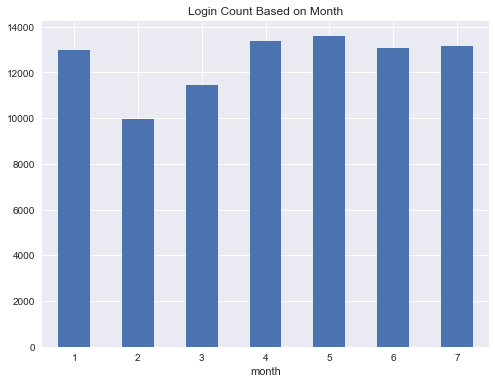

In [14]:
# From the graph below, we can tell January, April, May, June, July have higher demand, while \
# February has lower demand. Because incomplete record from August, we can't draw conclusion for\
# August.
plt.rcParams['figure.figsize'] = (8,6)
df_new.groupby('month').login_time_count.sum().plot('bar', rot=0)
plt.title('Login Count Based on Month')
plt.show()

In [15]:
df_new.groupby('month').login_time_count.sum()

month
1    12996
2     9971
3    11457
4    13377
5    13586
6    13057
7    13171
Name: login_time_count, dtype: int64

# Demand Pattern Based on Day of Month

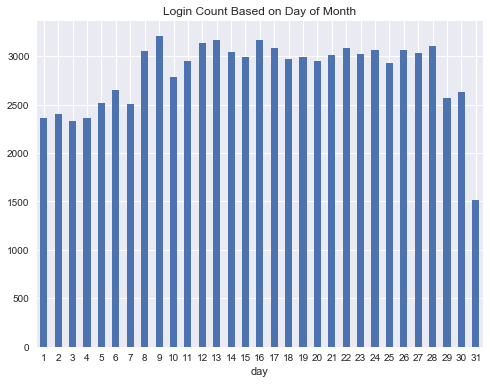

In [16]:
# We have lower demand at the end of the month and at the beginning of the month.
df_new.groupby('day').login_time_count.sum().plot('bar', rot=0)
plt.title('Login Count Based on Day of Month')
plt.show()

In [17]:
df_new.groupby('day').login_time_count.sum()

day
1     2363
2     2398
3     2334
4     2363
5     2516
6     2654
7     2502
8     3047
9     3205
10    2783
11    2945
12    3136
13    3167
14    3043
15    2986
16    3169
17    3087
18    2974
19    2991
20    2945
21    3009
22    3078
23    3020
24    3066
25    2929
26    3060
27    3033
28    3102
29    2567
30    2626
31    1517
Name: login_time_count, dtype: int64

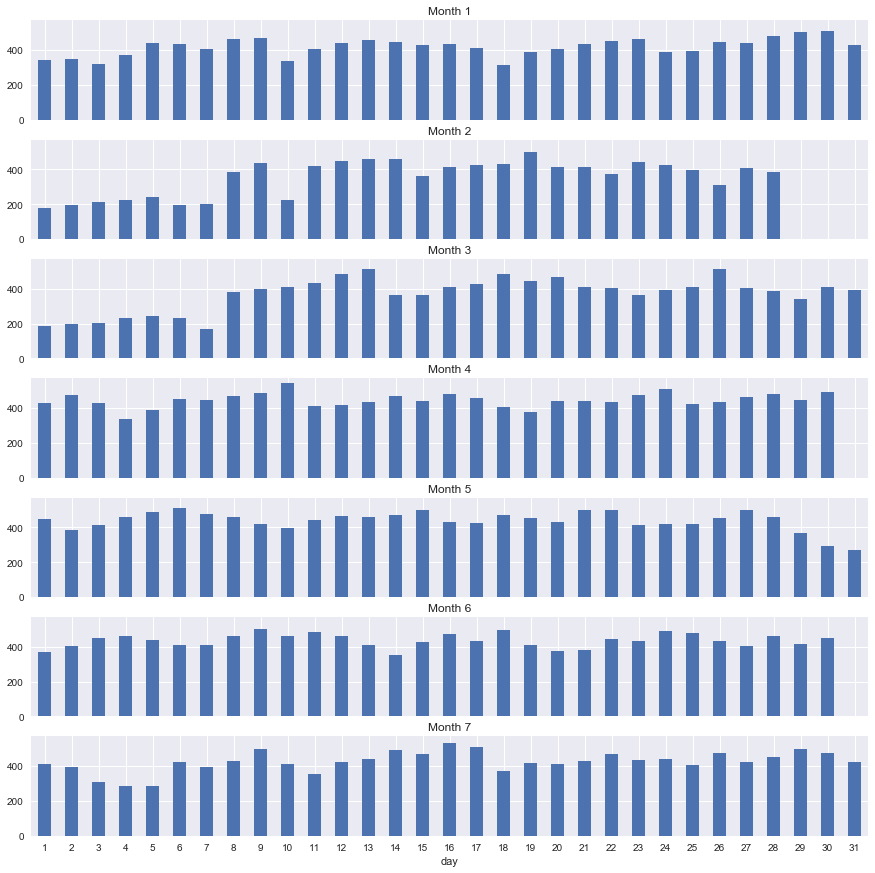

In [18]:
# Demand pattern based on day of each month. From the graphs below, we can tell the demand at \
# the beginning of February and March are much lower compared to the same periods in other months.
fig, axs = plt.subplots(7,1, sharey=True, sharex=True)
for index, month in enumerate(df_new.month.unique()):
    df_new[df_new.month == month].groupby('day').login_time_count.sum().plot('bar', axs[index],\
                                            rot=0, title = 'Month %s'%month, figsize=(15,15))

# Demand Pattern Based on Weekend or Not

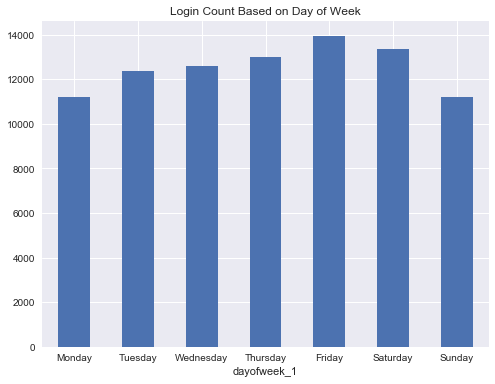

In [19]:
# Thursday, Friday and Saturday have higher demand while Monday and Sunday have lower demand.
df_new_dayofweek= df_new.groupby('dayofweek_1').login_time_count.sum()
df_new_dayofweek.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']).\
plot('bar',rot=0)
plt.title('Login Count Based on Day of Week')
plt.show()

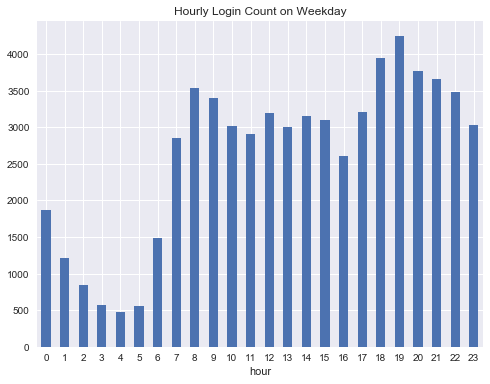

In [20]:
# If it's weekday, the higher demand time is from 6pm to 10pm.
df_new[df_new.weekend == 0].groupby('hour').login_time_count.sum().plot('bar', rot=0)
plt.title('Hourly Login Count on Weekday')
plt.show()

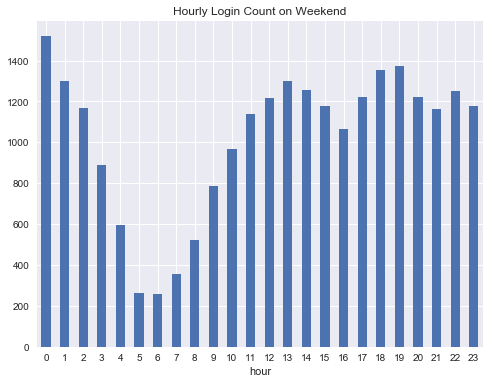

In [21]:
# If it's weekend, the higher demand time is from 6pm to 2am.
df_new[df_new.weekend == 1].groupby('hour').login_time_count.sum().plot('bar', rot=0)
plt.title('Hourly Login Count on Weekend')
plt.show()

# Hourly Demand Pattern Based on Each Weekday and       Weekend

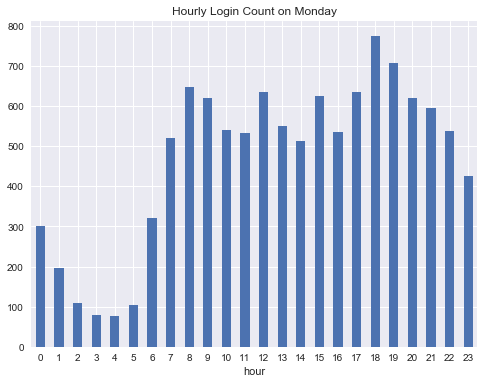

In [22]:
df_new[df_new.dayofweek_1 == 'Monday'].groupby('hour').login_time_count.sum().plot('bar', rot=0)
plt.title('Hourly Login Count on Monday')
plt.show()

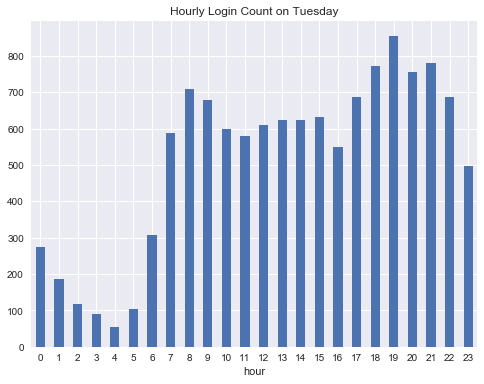

In [23]:
df_new[df_new.dayofweek_1 == 'Tuesday'].groupby('hour').login_time_count.sum().plot('bar', rot=0)
plt.title('Hourly Login Count on Tuesday')
plt.show()

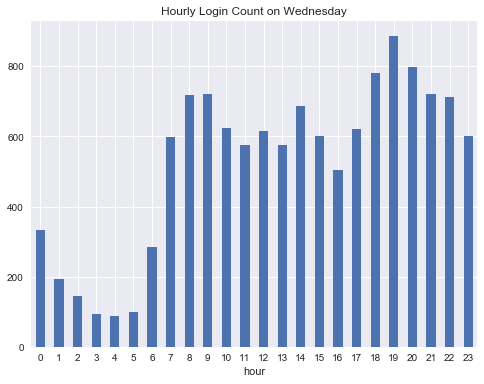

In [24]:
df_new[df_new.dayofweek_1 == 'Wednesday'].groupby('hour').login_time_count.sum().plot('bar', rot=0)
plt.title('Hourly Login Count on Wednesday')
plt.show()

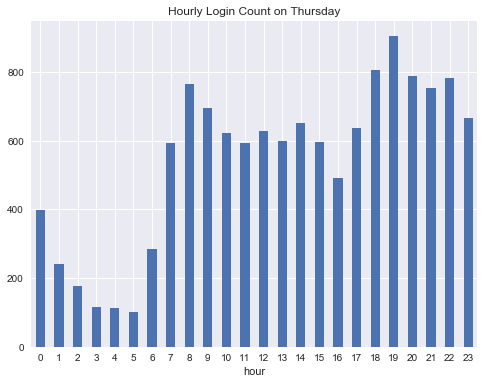

In [25]:
df_new[df_new.dayofweek_1== 'Thursday'].groupby('hour').login_time_count.sum().plot('bar', rot=0)
plt.title('Hourly Login Count on Thursday')
plt.show()

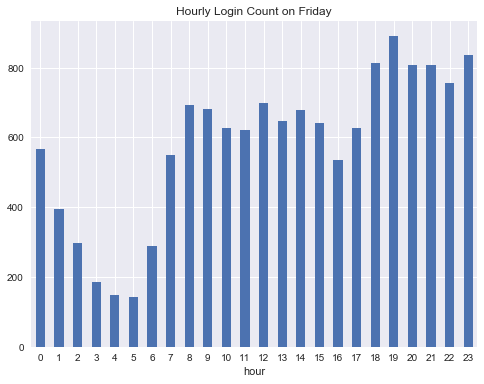

In [26]:
# Compared with other weekdays, demand during midnight on Friday is much higher. People tend \
# to go out for social activities on Friday night.
df_new[df_new.dayofweek_1 == 'Friday'].groupby('hour').login_time_count.sum().plot('bar', rot=0)
plt.title('Hourly Login Count on Friday')
plt.show()

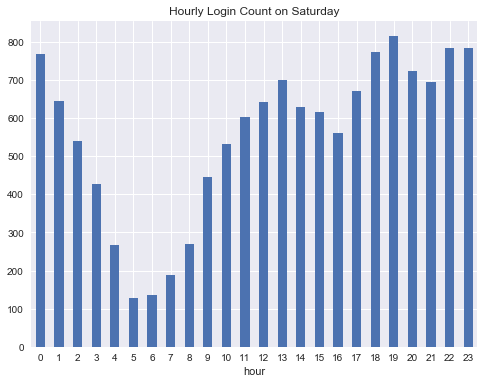

In [27]:
# Higher demand around noon time and in the evening on Saturday.
df_new[df_new.dayofweek_1 == 'Saturday'].groupby('hour').login_time_count.sum().plot('bar', rot=0)
plt.title('Hourly Login Count on Saturday')
plt.show()

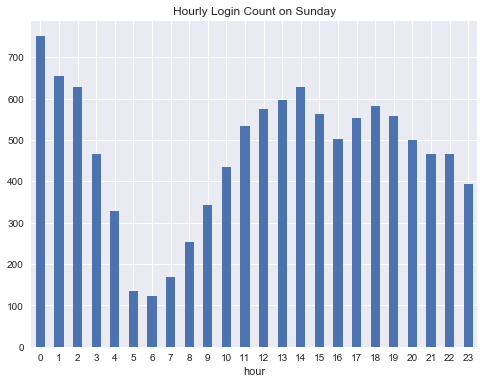

In [28]:
# Demand dies down in the evening on Sunday because people need to prepare for work on Monday.
df_new[df_new.dayofweek_1 == 'Sunday'].groupby('hour').login_time_count.sum().plot('bar', rot=0)
plt.title('Hourly Login Count on Sunday')
plt.show()

# Demand Pattern Based on Minute_Interval

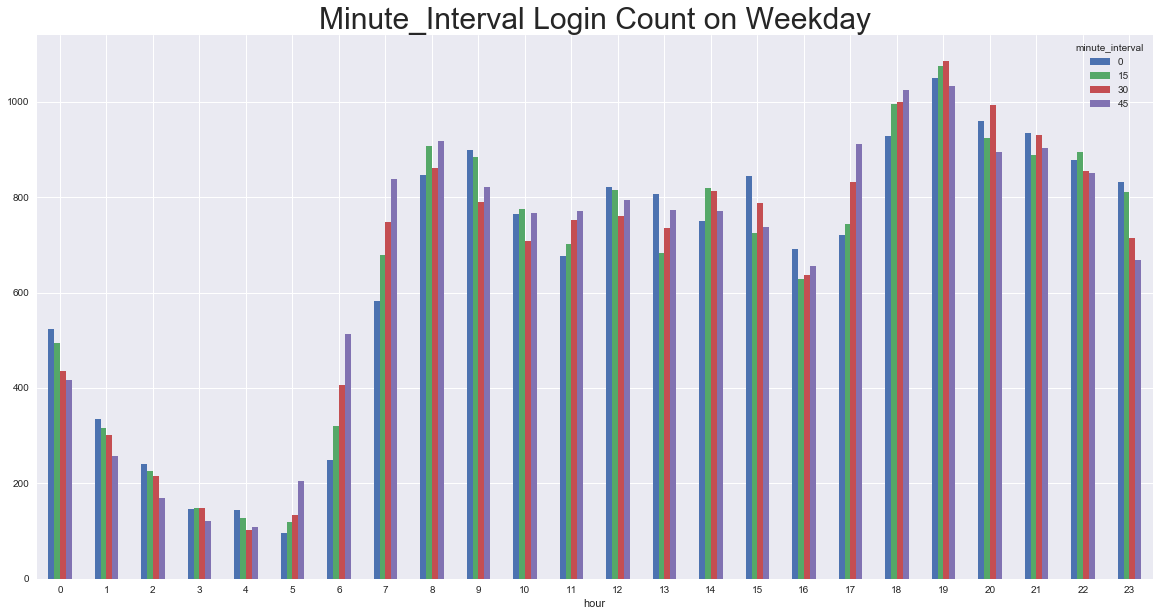

In [29]:
# We can tell demand goes down from 12am to 4am. Starting from 5am, demands goes up till 9am.\
# Demand is relatively stable from 9am to 4pm. After that, it goes up till 7pm, then goes down.
plt.rcParams['figure.figsize'] = (20,10)
df_new[df_new.weekend == 0].groupby(['hour', 'minute_interval']).login_time_count.sum().\
unstack().plot(kind='bar', rot=0)
plt.title('Minute_Interval Login Count on Weekday', fontsize=30)
plt.show()

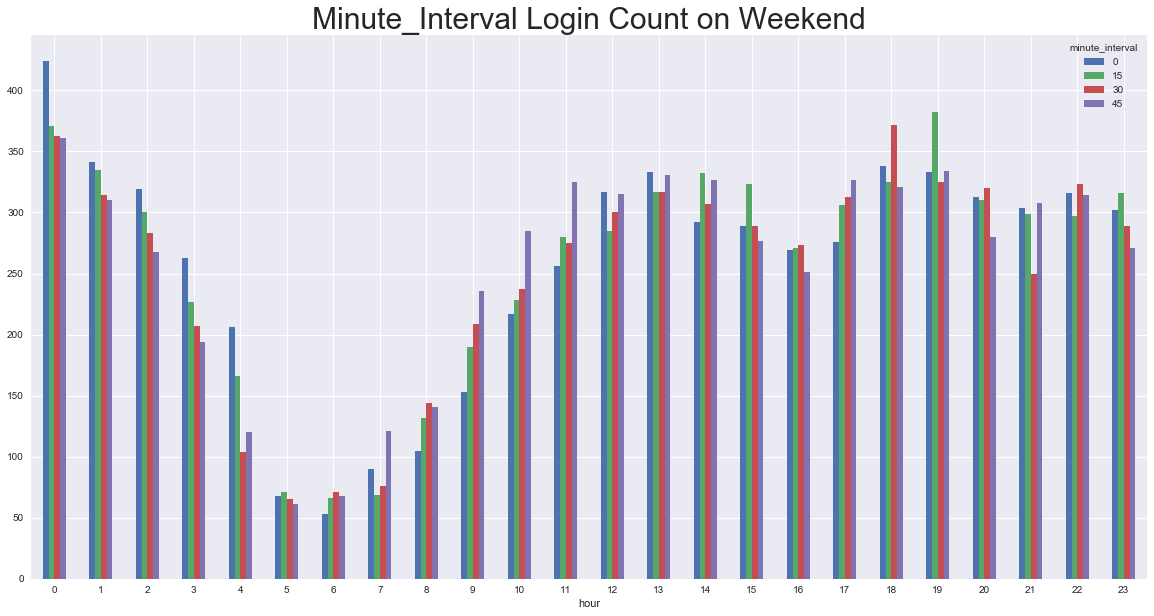

In [30]:
# Demand goes down from 12am to 5am, then is stable till 7am. It goes up till 2pm, then slowly\
# goes down till 5pm and maintains the high demand in the evening.
plt.rcParams['figure.figsize'] = (20,10)
df_new[df_new.weekend == 1].groupby(['hour', 'minute_interval']).login_time_count.sum().\
unstack().plot(kind='bar', rot=0)
plt.title('Minute_Interval Login Count on Weekend', fontsize=30)
plt.show()